In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Reshape, Flatten,
                                     LeakyReLU, BatchNormalization, Input,
                                     Conv2D, Conv2DTranspose)
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Enable eager execution
tf.config.run_functions_eagerly(True)

In [2]:
# Konfigurasi
LATENT_DIM = 100
BATCH_SIZE = 128
EPOCHS = 40
IMG_SHAPE = (28, 28, 1)

class StableDCGAN:
    """DCGAN dengan teknik stabilisasi modern"""

    def __init__(self):
        self.latent_dim = LATENT_DIM
        self.img_shape = IMG_SHAPE

        # Learning rates BERBEDA
        self.d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        self.g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

        # Build models
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()

        # Loss
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    def build_generator(self):
        """Generator dengan proper architecture"""
        model = Sequential(name='generator')

        # Foundation
        model.add(Dense(7 * 7 * 256, input_dim=self.latent_dim, use_bias=False))
        model.add(BatchNormalization())
        model.add(LeakyReLU(negative_slope=0.2))
        model.add(Reshape((7, 7, 256)))

        # Upsample 1: 7x7 -> 14x14
        model.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(LeakyReLU(negative_slope=0.2))

        # Upsample 2: 14x14 -> 28x28
        model.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(LeakyReLU(negative_slope=0.2))

        # Output
        model.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh', use_bias=False))

        return model

    def build_discriminator(self):
        """Discriminator dengan dropout untuk regularisasi"""
        model = Sequential(name='discriminator')

        # Layer 1
        model.add(Conv2D(64, kernel_size=5, strides=2, padding='same',
                        input_shape=self.img_shape))
        model.add(LeakyReLU(negative_slope=0.2))
        model.add(tf.keras.layers.Dropout(0.3))

        # Layer 2
        model.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
        model.add(LeakyReLU(negative_slope=0.2))
        model.add(tf.keras.layers.Dropout(0.3))

        # Output
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        return model

    @tf.function
    def train_step(self, real_images):
        """Single training step"""
        batch_size = tf.shape(real_images)[0]

        # Generate noise
        noise = tf.random.normal([batch_size, self.latent_dim])

        # Train discriminator
        with tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # Losses
            d_loss_real = self.cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
            d_loss_fake = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
            d_loss = d_loss_real + d_loss_fake

        gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        # Train generator
        noise = tf.random.normal([batch_size, self.latent_dim])

        with tf.GradientTape() as gen_tape:
            generated_images = self.generator(noise, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            g_loss = self.cross_entropy(tf.ones_like(fake_output), fake_output)

        gradients_of_generator = gen_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

        # Calculate accuracy
        real_acc = tf.reduce_mean(tf.cast(real_output > 0.5, tf.float32))
        fake_acc = tf.reduce_mean(tf.cast(fake_output < 0.5, tf.float32))
        d_acc = (real_acc + fake_acc) / 2

        return d_loss, g_loss, d_acc

    def load_data(self):
        """Load MNIST"""
        (X_train, _), (_, _) = mnist.load_data()
        X_train = X_train.astype('float32')
        X_train = (X_train - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=-1)
        return X_train

    def train(self, epochs, batch_size):
        """Training loop"""
        X_train = self.load_data()
        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(60000).batch(batch_size)

        history = {'d_loss': [], 'g_loss': [], 'd_acc': []}

        print(f"\n{'='*70}")
        print(f"Training Stable DCGAN: {epochs} epochs")
        print(f"Using TensorFlow GradientTape for stable training")
        print(f"{'='*70}\n")

        for epoch in range(epochs):
            epoch_d_loss = []
            epoch_g_loss = []
            epoch_d_acc = []

            for i, batch in enumerate(dataset):
                d_loss, g_loss, d_acc = self.train_step(batch)

                epoch_d_loss.append(float(d_loss))
                epoch_g_loss.append(float(g_loss))
                epoch_d_acc.append(float(d_acc))

                if i % 100 == 0:
                    print(f"Epoch {epoch+1}/{epochs} | Batch {i} | "
                          f"D_loss: {d_loss:.4f} | D_acc: {d_acc*100:.1f}% | "
                          f"G_loss: {g_loss:.4f}")

            # Epoch summary
            avg_d_loss = np.mean(epoch_d_loss)
            avg_g_loss = np.mean(epoch_g_loss)
            avg_d_acc = np.mean(epoch_d_acc) * 100

            history['d_loss'].append(avg_d_loss)
            history['g_loss'].append(avg_g_loss)
            history['d_acc'].append(avg_d_acc)

            print(f"\n{'='*70}")
            print(f"EPOCH {epoch+1} SUMMARY")
            print(f"D_loss: {avg_d_loss:.4f} | D_acc: {avg_d_acc:.1f}% | G_loss: {avg_g_loss:.4f}")

            if avg_d_acc < 30:
                print("⚠️  D too weak - Generator dominating")
            elif avg_d_acc > 80:
                print("⚠️  D too strong - Training may fail")
            elif 40 <= avg_d_acc <= 70:
                print("✅ Training balanced!")

            print(f"{'='*70}\n")

            # Generate samples
            if (epoch + 1) % 5 == 0 or epoch == 0:
                self.generate_images(epoch + 1)

        return history

    def generate_images(self, epoch, n=25):
        """Generate images"""
        noise = tf.random.normal([n, self.latent_dim])
        gen_imgs = self.generator(noise, training=False)
        gen_imgs = gen_imgs.numpy()
        gen_imgs = 0.5 * gen_imgs + 0.5

        dim = int(np.sqrt(n))
        fig, axes = plt.subplots(dim, dim, figsize=(10, 10))

        for i in range(dim):
            for j in range(dim):
                idx = i * dim + j
                axes[i, j].imshow(gen_imgs[idx, :, :, 0], cmap='gray')
                axes[i, j].axis('off')

        plt.suptitle(f'Generated Images - Epoch {epoch}', fontsize=16, y=0.98)
        plt.tight_layout()
        plt.show()

    def plot_history(self, history):
        """Plot history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        epochs = range(1, len(history['d_loss']) + 1)

        ax1.plot(epochs, history['d_loss'], label='Discriminator', linewidth=2, color='blue')
        ax1.plot(epochs, history['g_loss'], label='Generator', linewidth=2, color='orange')
        ax1.set_xlabel('Epoch', fontsize=12)
        ax1.set_ylabel('Loss', fontsize=12)
        ax1.set_title('Training Losses', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        ax2.plot(epochs, history['d_acc'], color='green', linewidth=2)
        ax2.axhline(y=50, color='r', linestyle='--', linewidth=2, label='Ideal')
        ax2.fill_between(epochs, 40, 70, alpha=0.2, color='green', label='Good range')
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Accuracy (%)', fontsize=12)
        ax2.set_title('Discriminator Accuracy', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim([0, 100])

        plt.tight_layout()
        plt.show()

GENERATOR ARCHITECTURE


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 1)      │         1,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)


DISCRIMINATOR ARCHITECTURE


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)


Pre-training samples...


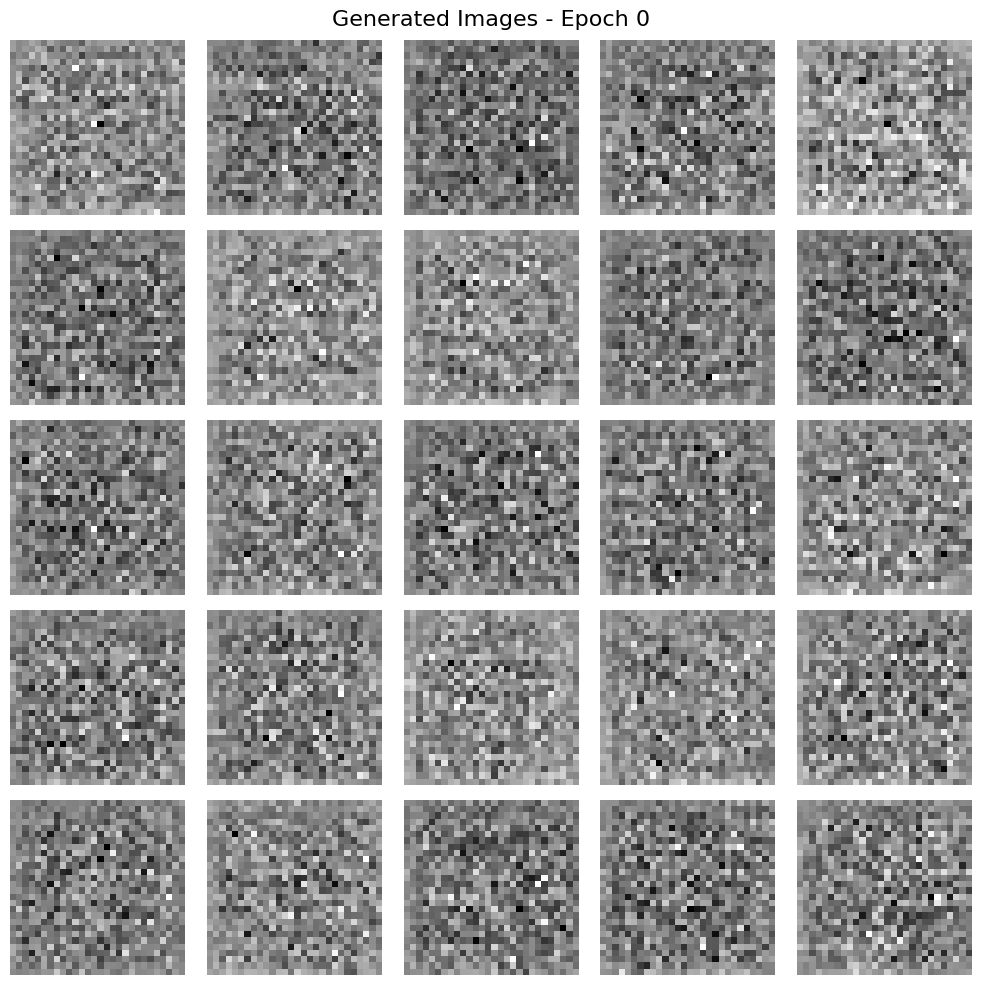

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training Stable DCGAN: 40 epochs
Using TensorFlow GradientTape for stable training

Epoch 1/40 | Batch 0 | D_loss: 1.3844 | D_acc: 54.3% | G_loss: 0.6833
Epoch 1/40 | Batch 100 | D_loss: 1.3767 | D_acc: 53.1% | G_loss: 0.8026
Epoch 1/40 | Batch 200 | D_loss: 1.3715 | D_acc: 51.6% | G_loss: 0.8002
Epoch 1/40 | Batch 300 | D_loss: 1.3525 | D_acc: 53.9% | G_loss: 0.8549
Epoch 1/40 | Batch 400 | D_loss: 1.3671 | D_acc: 49.2% | G_loss: 0.7854

EPOCH 1 SUMMARY
D_loss: 1.3706 | D_acc: 54.7% | G_loss: 0.8082
✅ Training balanced!



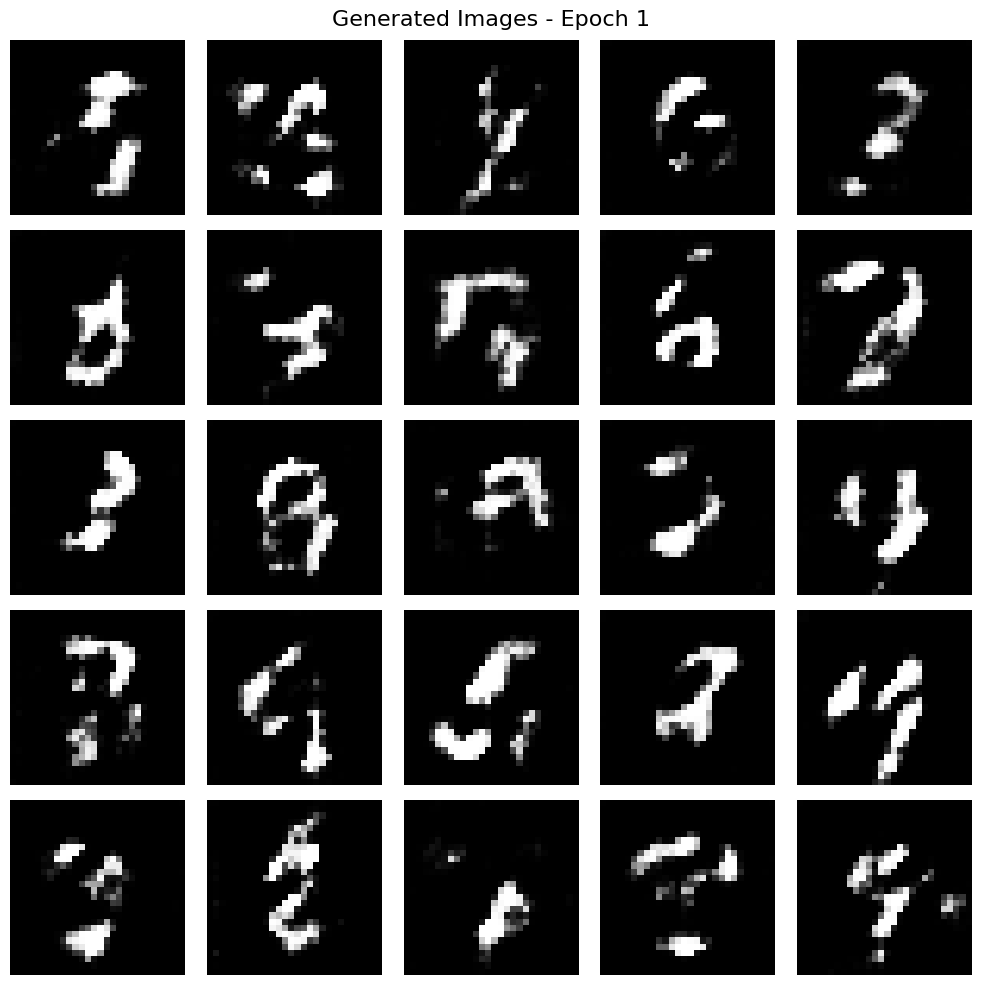

Epoch 2/40 | Batch 0 | D_loss: 1.3534 | D_acc: 53.5% | G_loss: 0.8508
Epoch 2/40 | Batch 100 | D_loss: 1.3531 | D_acc: 57.4% | G_loss: 0.7603
Epoch 2/40 | Batch 200 | D_loss: 1.3822 | D_acc: 62.9% | G_loss: 0.7637
Epoch 2/40 | Batch 300 | D_loss: 1.3180 | D_acc: 57.4% | G_loss: 1.0032
Epoch 2/40 | Batch 400 | D_loss: 1.3141 | D_acc: 68.8% | G_loss: 0.9292

EPOCH 2 SUMMARY
D_loss: 1.3388 | D_acc: 59.4% | G_loss: 0.8627
✅ Training balanced!

Epoch 3/40 | Batch 0 | D_loss: 1.3608 | D_acc: 48.4% | G_loss: 0.8272
Epoch 3/40 | Batch 100 | D_loss: 1.3514 | D_acc: 68.8% | G_loss: 0.8656
Epoch 3/40 | Batch 200 | D_loss: 1.3687 | D_acc: 53.9% | G_loss: 0.9664
Epoch 3/40 | Batch 300 | D_loss: 1.3640 | D_acc: 51.6% | G_loss: 0.8528
Epoch 3/40 | Batch 400 | D_loss: 1.3804 | D_acc: 56.6% | G_loss: 0.8236

EPOCH 3 SUMMARY
D_loss: 1.3518 | D_acc: 57.5% | G_loss: 0.8484
✅ Training balanced!

Epoch 4/40 | Batch 0 | D_loss: 1.3453 | D_acc: 67.2% | G_loss: 0.9140
Epoch 4/40 | Batch 100 | D_loss: 1.3504 | 

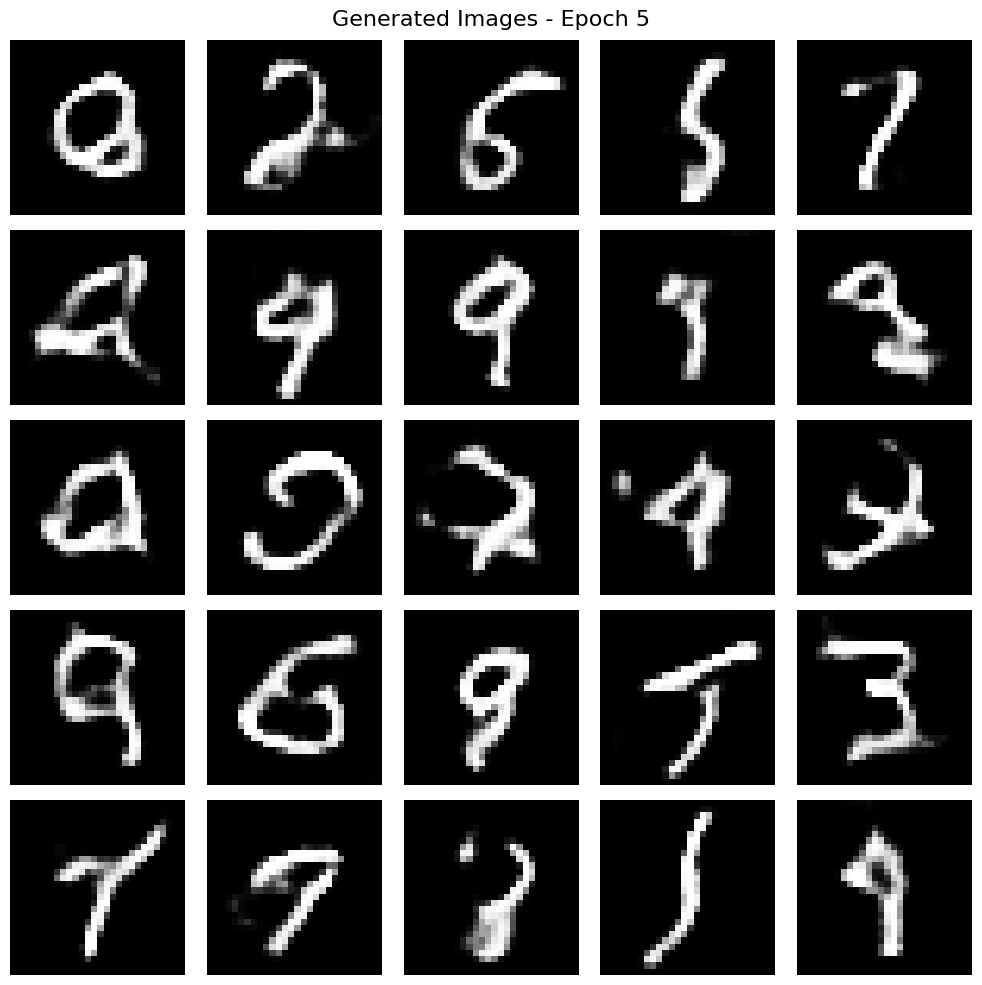

Epoch 6/40 | Batch 0 | D_loss: 1.3652 | D_acc: 53.9% | G_loss: 0.8677
Epoch 6/40 | Batch 100 | D_loss: 1.3606 | D_acc: 47.3% | G_loss: 0.8446
Epoch 6/40 | Batch 200 | D_loss: 1.3498 | D_acc: 71.1% | G_loss: 0.9137
Epoch 6/40 | Batch 300 | D_loss: 1.3315 | D_acc: 64.8% | G_loss: 0.8731
Epoch 6/40 | Batch 400 | D_loss: 1.3627 | D_acc: 51.2% | G_loss: 0.8184

EPOCH 6 SUMMARY
D_loss: 1.3492 | D_acc: 57.1% | G_loss: 0.8476
✅ Training balanced!

Epoch 7/40 | Batch 0 | D_loss: 1.3236 | D_acc: 57.4% | G_loss: 0.8792
Epoch 7/40 | Batch 100 | D_loss: 1.3433 | D_acc: 61.3% | G_loss: 0.8640
Epoch 7/40 | Batch 200 | D_loss: 1.3548 | D_acc: 67.2% | G_loss: 0.8944
Epoch 7/40 | Batch 300 | D_loss: 1.3469 | D_acc: 51.6% | G_loss: 0.8205
Epoch 7/40 | Batch 400 | D_loss: 1.3659 | D_acc: 37.5% | G_loss: 0.7617

EPOCH 7 SUMMARY
D_loss: 1.3477 | D_acc: 57.0% | G_loss: 0.8447
✅ Training balanced!

Epoch 8/40 | Batch 0 | D_loss: 1.3707 | D_acc: 57.0% | G_loss: 0.8537
Epoch 8/40 | Batch 100 | D_loss: 1.3374 | 

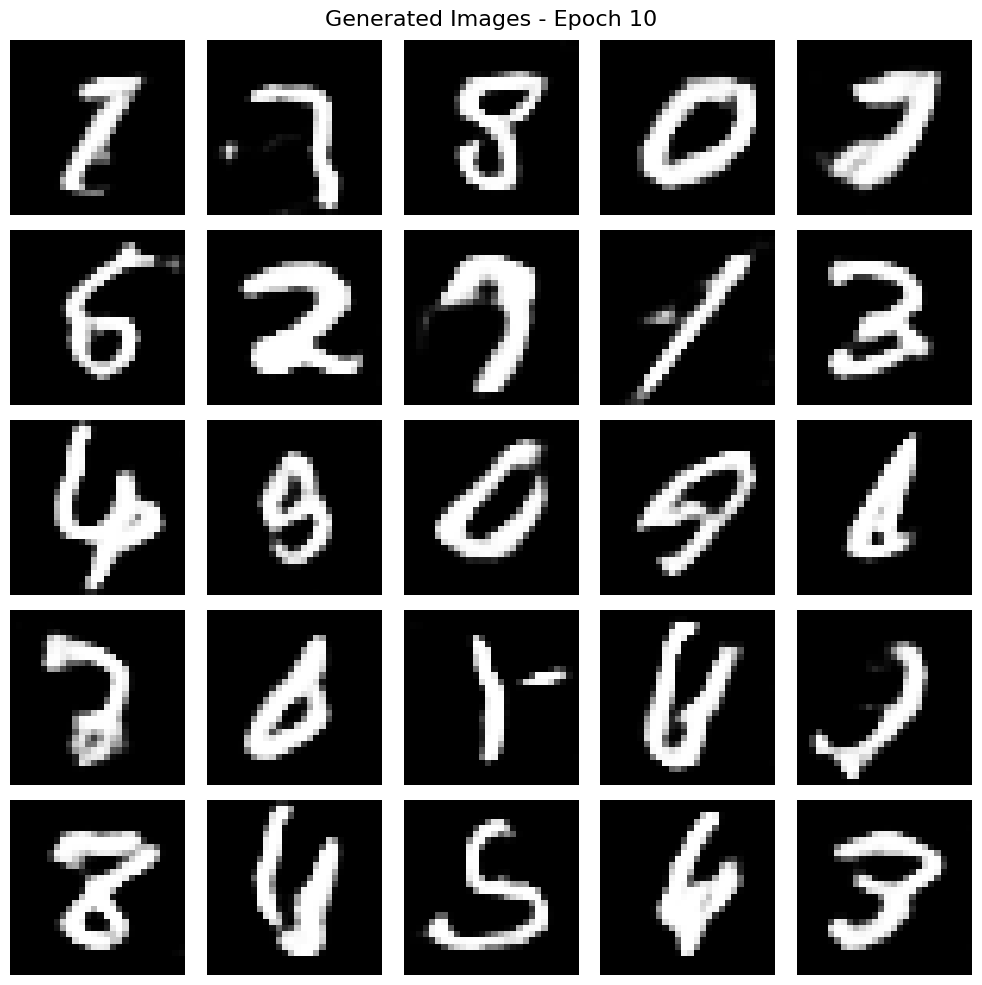

Epoch 11/40 | Batch 0 | D_loss: 1.3204 | D_acc: 74.6% | G_loss: 0.8568
Epoch 11/40 | Batch 100 | D_loss: 1.3260 | D_acc: 65.6% | G_loss: 0.8865
Epoch 11/40 | Batch 200 | D_loss: 1.4110 | D_acc: 58.2% | G_loss: 0.9388
Epoch 11/40 | Batch 300 | D_loss: 1.3447 | D_acc: 55.1% | G_loss: 0.7834
Epoch 11/40 | Batch 400 | D_loss: 1.3376 | D_acc: 60.5% | G_loss: 0.9018

EPOCH 11 SUMMARY
D_loss: 1.3532 | D_acc: 57.3% | G_loss: 0.8544
✅ Training balanced!

Epoch 12/40 | Batch 0 | D_loss: 1.3566 | D_acc: 56.2% | G_loss: 0.8592
Epoch 12/40 | Batch 100 | D_loss: 1.3429 | D_acc: 57.0% | G_loss: 0.8316
Epoch 12/40 | Batch 200 | D_loss: 1.3306 | D_acc: 52.7% | G_loss: 0.8011
Epoch 12/40 | Batch 300 | D_loss: 1.3244 | D_acc: 50.0% | G_loss: 0.8394
Epoch 12/40 | Batch 400 | D_loss: 1.3646 | D_acc: 55.1% | G_loss: 0.8415

EPOCH 12 SUMMARY
D_loss: 1.3515 | D_acc: 57.0% | G_loss: 0.8513
✅ Training balanced!

Epoch 13/40 | Batch 0 | D_loss: 1.3588 | D_acc: 40.6% | G_loss: 0.7710
Epoch 13/40 | Batch 100 | D_l

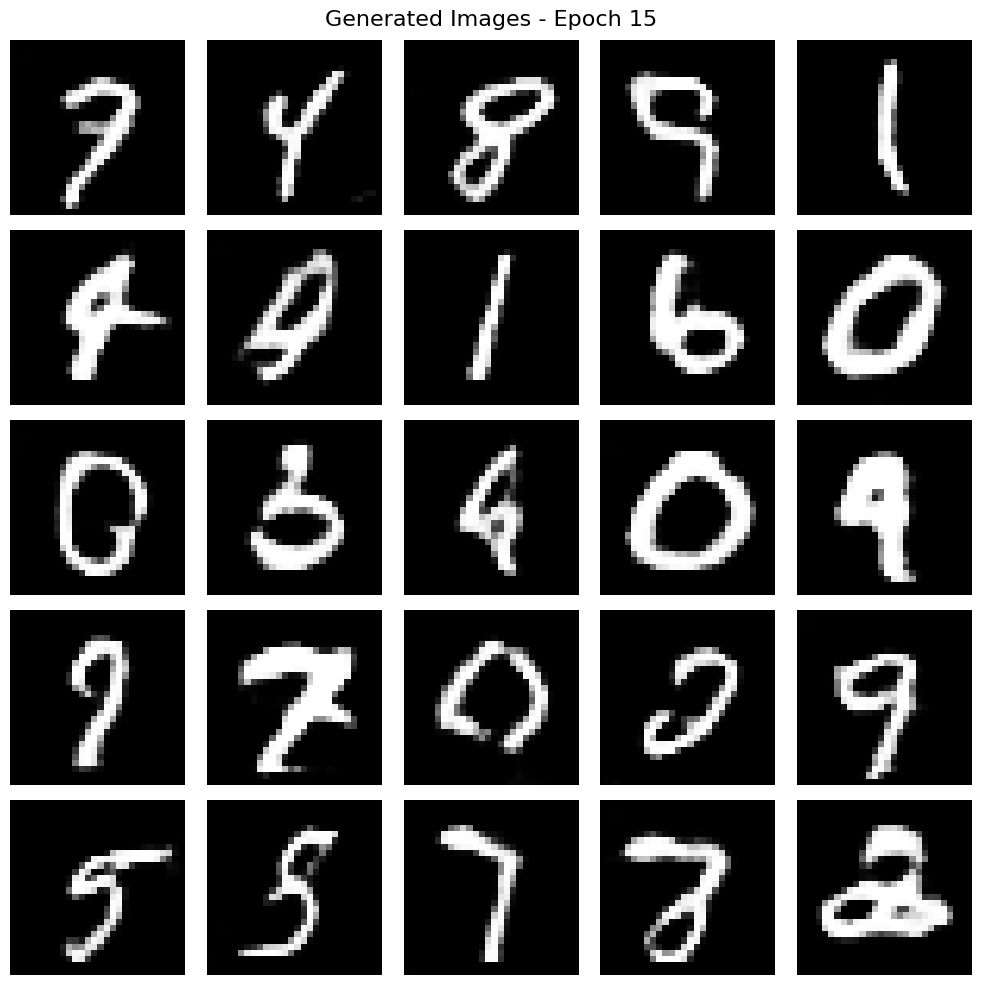

Epoch 16/40 | Batch 0 | D_loss: 1.3364 | D_acc: 68.4% | G_loss: 0.8532
Epoch 16/40 | Batch 100 | D_loss: 1.3421 | D_acc: 62.1% | G_loss: 0.9045
Epoch 16/40 | Batch 200 | D_loss: 1.4170 | D_acc: 59.8% | G_loss: 0.9886
Epoch 16/40 | Batch 300 | D_loss: 1.3081 | D_acc: 70.3% | G_loss: 0.9551
Epoch 16/40 | Batch 400 | D_loss: 1.3663 | D_acc: 60.9% | G_loss: 0.8902

EPOCH 16 SUMMARY
D_loss: 1.3512 | D_acc: 56.8% | G_loss: 0.8520
✅ Training balanced!

Epoch 17/40 | Batch 0 | D_loss: 1.3292 | D_acc: 53.5% | G_loss: 0.8354
Epoch 17/40 | Batch 100 | D_loss: 1.3891 | D_acc: 59.4% | G_loss: 0.9380
Epoch 17/40 | Batch 200 | D_loss: 1.3796 | D_acc: 52.0% | G_loss: 0.9389
Epoch 17/40 | Batch 300 | D_loss: 1.3454 | D_acc: 63.7% | G_loss: 0.8570
Epoch 17/40 | Batch 400 | D_loss: 1.3367 | D_acc: 52.3% | G_loss: 0.8475

EPOCH 17 SUMMARY
D_loss: 1.3523 | D_acc: 56.8% | G_loss: 0.8524
✅ Training balanced!

Epoch 18/40 | Batch 0 | D_loss: 1.3557 | D_acc: 54.3% | G_loss: 0.8467
Epoch 18/40 | Batch 100 | D_l

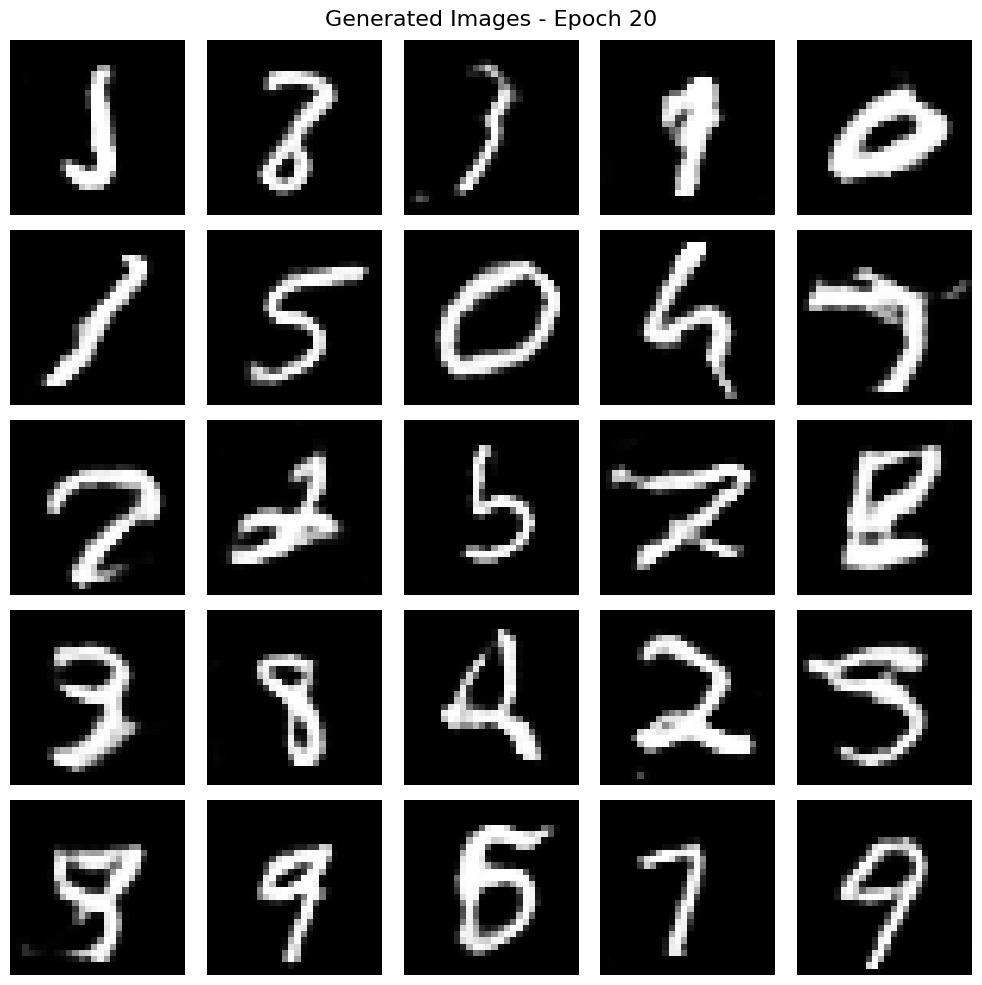

Epoch 21/40 | Batch 0 | D_loss: 1.3859 | D_acc: 50.0% | G_loss: 0.8775
Epoch 21/40 | Batch 100 | D_loss: 1.3441 | D_acc: 57.4% | G_loss: 0.8282
Epoch 21/40 | Batch 200 | D_loss: 1.3783 | D_acc: 54.7% | G_loss: 0.9690
Epoch 21/40 | Batch 300 | D_loss: 1.3281 | D_acc: 50.8% | G_loss: 0.7858
Epoch 21/40 | Batch 400 | D_loss: 1.3391 | D_acc: 57.4% | G_loss: 0.8114

EPOCH 21 SUMMARY
D_loss: 1.3506 | D_acc: 56.9% | G_loss: 0.8545
✅ Training balanced!

Epoch 22/40 | Batch 0 | D_loss: 1.3656 | D_acc: 54.7% | G_loss: 0.8530
Epoch 22/40 | Batch 100 | D_loss: 1.3650 | D_acc: 43.8% | G_loss: 0.8097
Epoch 22/40 | Batch 200 | D_loss: 1.3547 | D_acc: 55.9% | G_loss: 0.8383
Epoch 22/40 | Batch 300 | D_loss: 1.3601 | D_acc: 54.3% | G_loss: 0.8294
Epoch 22/40 | Batch 400 | D_loss: 1.3523 | D_acc: 63.7% | G_loss: 0.8656

EPOCH 22 SUMMARY
D_loss: 1.3511 | D_acc: 56.1% | G_loss: 0.8491
✅ Training balanced!

Epoch 23/40 | Batch 0 | D_loss: 1.3629 | D_acc: 56.2% | G_loss: 0.7927
Epoch 23/40 | Batch 100 | D_l

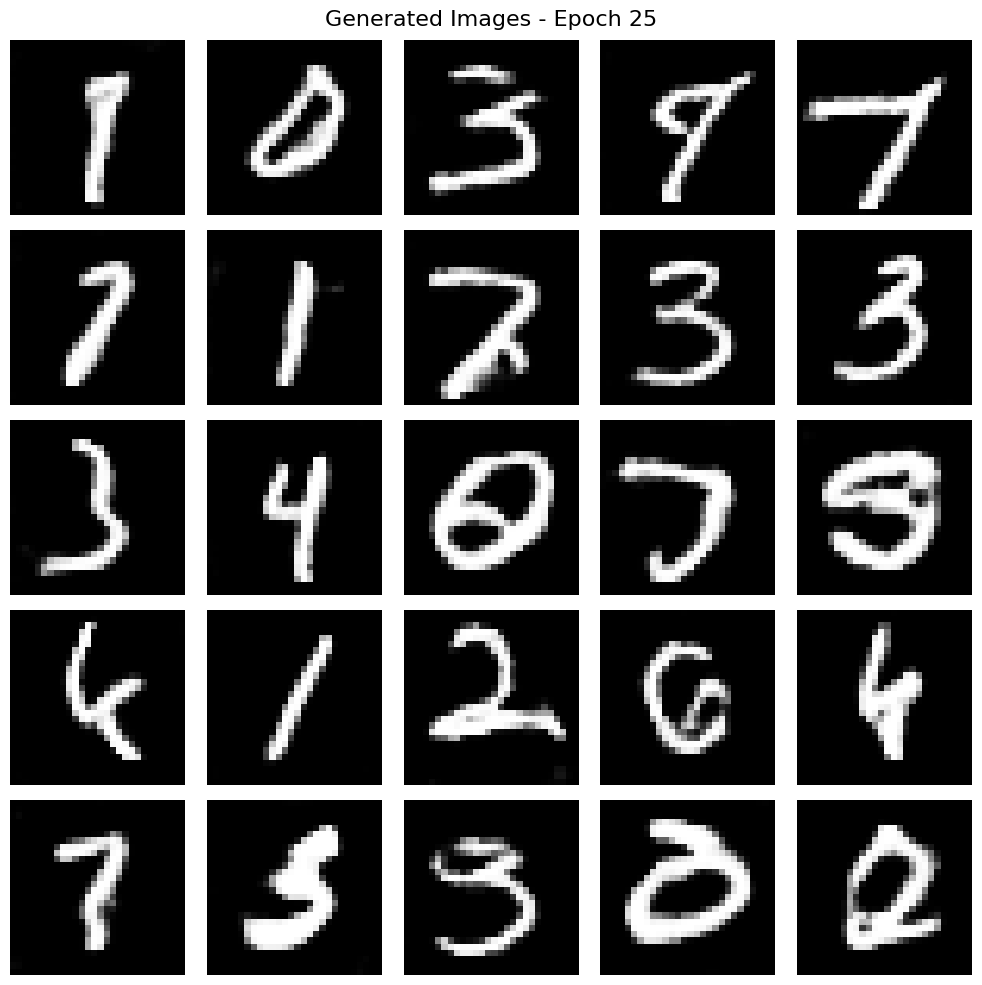

Epoch 26/40 | Batch 0 | D_loss: 1.3487 | D_acc: 45.7% | G_loss: 0.8295
Epoch 26/40 | Batch 100 | D_loss: 1.3694 | D_acc: 52.7% | G_loss: 0.8995
Epoch 26/40 | Batch 200 | D_loss: 1.3338 | D_acc: 66.8% | G_loss: 0.8644
Epoch 26/40 | Batch 300 | D_loss: 1.3423 | D_acc: 47.7% | G_loss: 0.8128
Epoch 26/40 | Batch 400 | D_loss: 1.3725 | D_acc: 52.7% | G_loss: 0.8662

EPOCH 26 SUMMARY
D_loss: 1.3514 | D_acc: 56.1% | G_loss: 0.8511
✅ Training balanced!

Epoch 27/40 | Batch 0 | D_loss: 1.3392 | D_acc: 47.3% | G_loss: 0.8228
Epoch 27/40 | Batch 100 | D_loss: 1.3452 | D_acc: 57.0% | G_loss: 0.8457
Epoch 27/40 | Batch 200 | D_loss: 1.3299 | D_acc: 57.4% | G_loss: 0.8301
Epoch 27/40 | Batch 300 | D_loss: 1.3531 | D_acc: 55.1% | G_loss: 0.8505
Epoch 27/40 | Batch 400 | D_loss: 1.3627 | D_acc: 55.9% | G_loss: 0.8353

EPOCH 27 SUMMARY
D_loss: 1.3501 | D_acc: 56.0% | G_loss: 0.8478
✅ Training balanced!

Epoch 28/40 | Batch 0 | D_loss: 1.3415 | D_acc: 48.4% | G_loss: 0.7531
Epoch 28/40 | Batch 100 | D_l

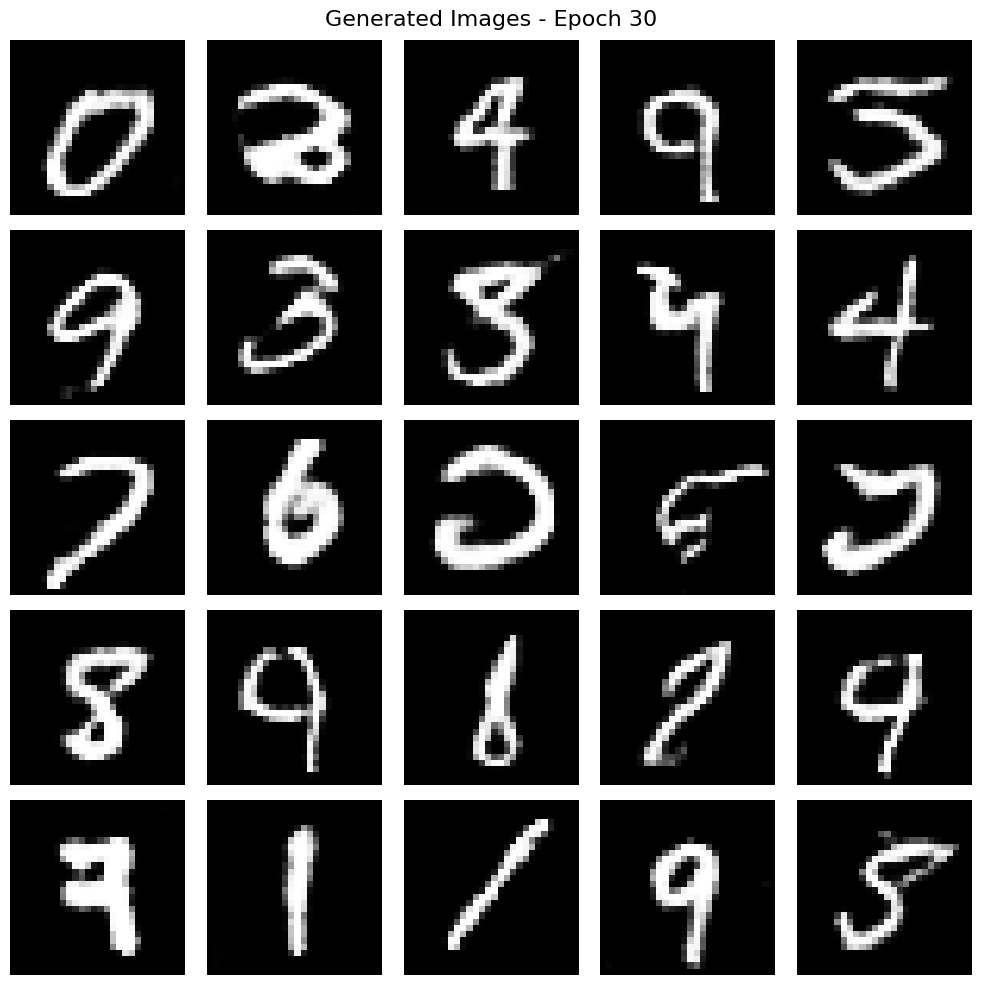

Epoch 31/40 | Batch 0 | D_loss: 1.3831 | D_acc: 46.5% | G_loss: 0.8076
Epoch 31/40 | Batch 100 | D_loss: 1.3414 | D_acc: 51.2% | G_loss: 0.7957
Epoch 31/40 | Batch 200 | D_loss: 1.3811 | D_acc: 41.8% | G_loss: 0.7545
Epoch 31/40 | Batch 300 | D_loss: 1.3714 | D_acc: 54.7% | G_loss: 0.8945
Epoch 31/40 | Batch 400 | D_loss: 1.3712 | D_acc: 62.9% | G_loss: 0.8749

EPOCH 31 SUMMARY
D_loss: 1.3528 | D_acc: 55.9% | G_loss: 0.8474
✅ Training balanced!

Epoch 32/40 | Batch 0 | D_loss: 1.3700 | D_acc: 58.6% | G_loss: 0.8754
Epoch 32/40 | Batch 100 | D_loss: 1.3531 | D_acc: 57.4% | G_loss: 0.8507
Epoch 32/40 | Batch 200 | D_loss: 1.3716 | D_acc: 55.9% | G_loss: 0.7808
Epoch 32/40 | Batch 300 | D_loss: 1.3488 | D_acc: 52.3% | G_loss: 0.8023
Epoch 32/40 | Batch 400 | D_loss: 1.3547 | D_acc: 53.1% | G_loss: 0.8089

EPOCH 32 SUMMARY
D_loss: 1.3534 | D_acc: 55.9% | G_loss: 0.8492
✅ Training balanced!

Epoch 33/40 | Batch 0 | D_loss: 1.3505 | D_acc: 59.4% | G_loss: 0.8329
Epoch 33/40 | Batch 100 | D_l

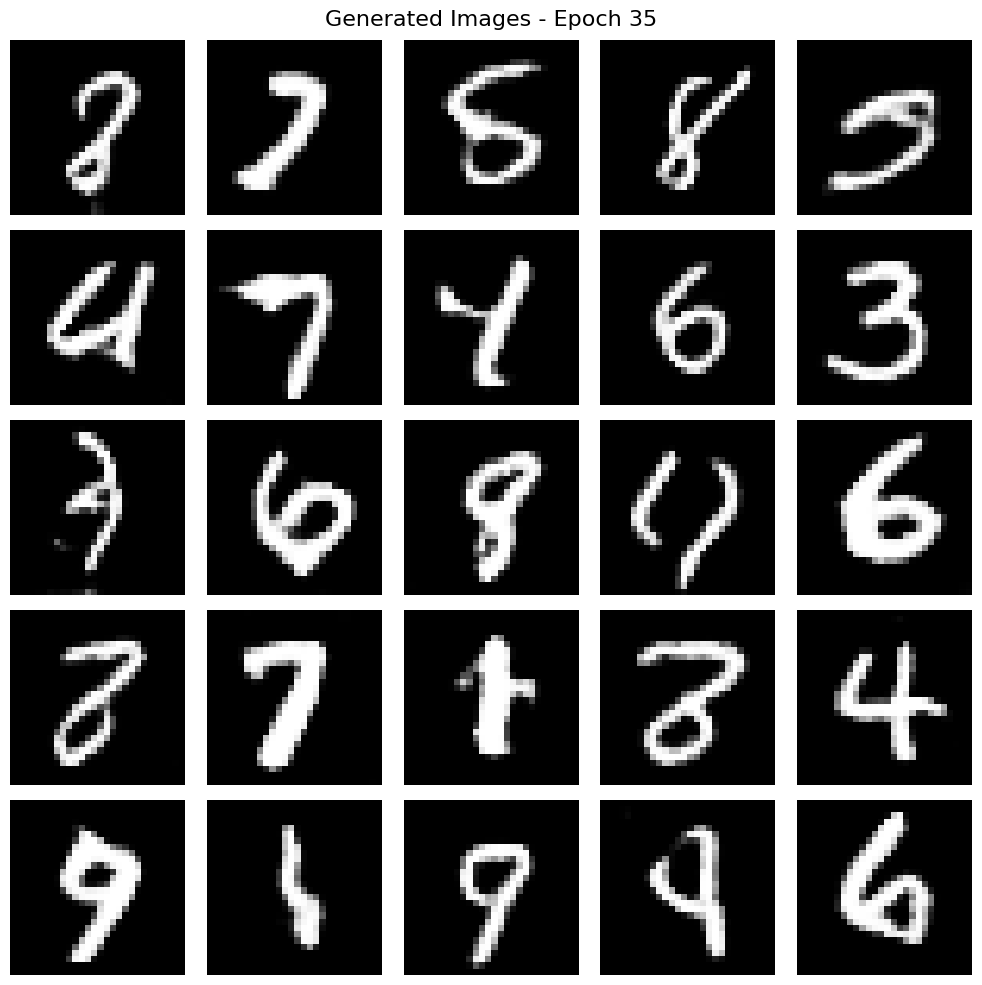

Epoch 36/40 | Batch 0 | D_loss: 1.3514 | D_acc: 71.1% | G_loss: 0.8893
Epoch 36/40 | Batch 100 | D_loss: 1.3678 | D_acc: 51.2% | G_loss: 0.8460
Epoch 36/40 | Batch 200 | D_loss: 1.3524 | D_acc: 53.1% | G_loss: 0.8264
Epoch 36/40 | Batch 300 | D_loss: 1.3656 | D_acc: 61.3% | G_loss: 0.9080
Epoch 36/40 | Batch 400 | D_loss: 1.3310 | D_acc: 58.6% | G_loss: 0.8771

EPOCH 36 SUMMARY
D_loss: 1.3529 | D_acc: 56.1% | G_loss: 0.8489
✅ Training balanced!

Epoch 37/40 | Batch 0 | D_loss: 1.3422 | D_acc: 56.6% | G_loss: 0.8584
Epoch 37/40 | Batch 100 | D_loss: 1.3610 | D_acc: 50.4% | G_loss: 0.7899
Epoch 37/40 | Batch 200 | D_loss: 1.3398 | D_acc: 60.5% | G_loss: 0.8578
Epoch 37/40 | Batch 300 | D_loss: 1.3860 | D_acc: 45.7% | G_loss: 0.8412
Epoch 37/40 | Batch 400 | D_loss: 1.3554 | D_acc: 56.2% | G_loss: 0.8585

EPOCH 37 SUMMARY
D_loss: 1.3532 | D_acc: 55.8% | G_loss: 0.8478
✅ Training balanced!

Epoch 38/40 | Batch 0 | D_loss: 1.3641 | D_acc: 48.4% | G_loss: 0.8427
Epoch 38/40 | Batch 100 | D_l

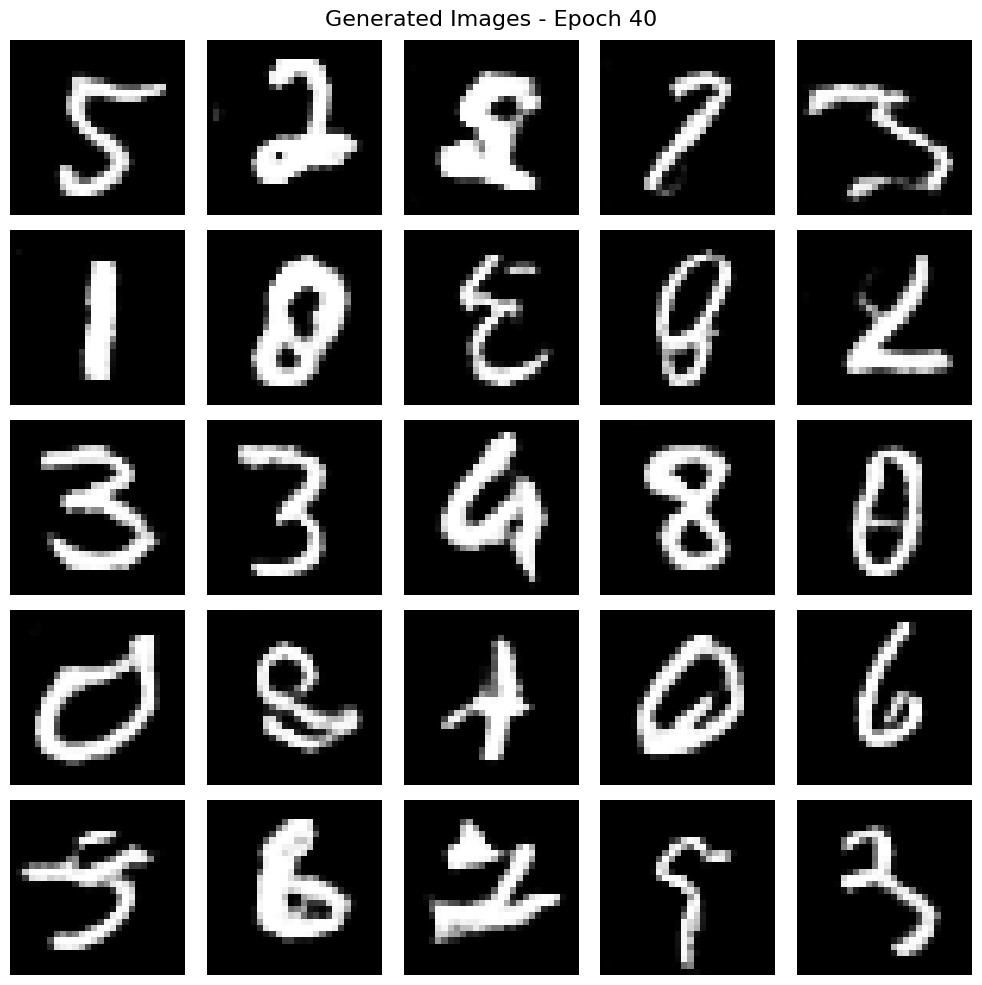

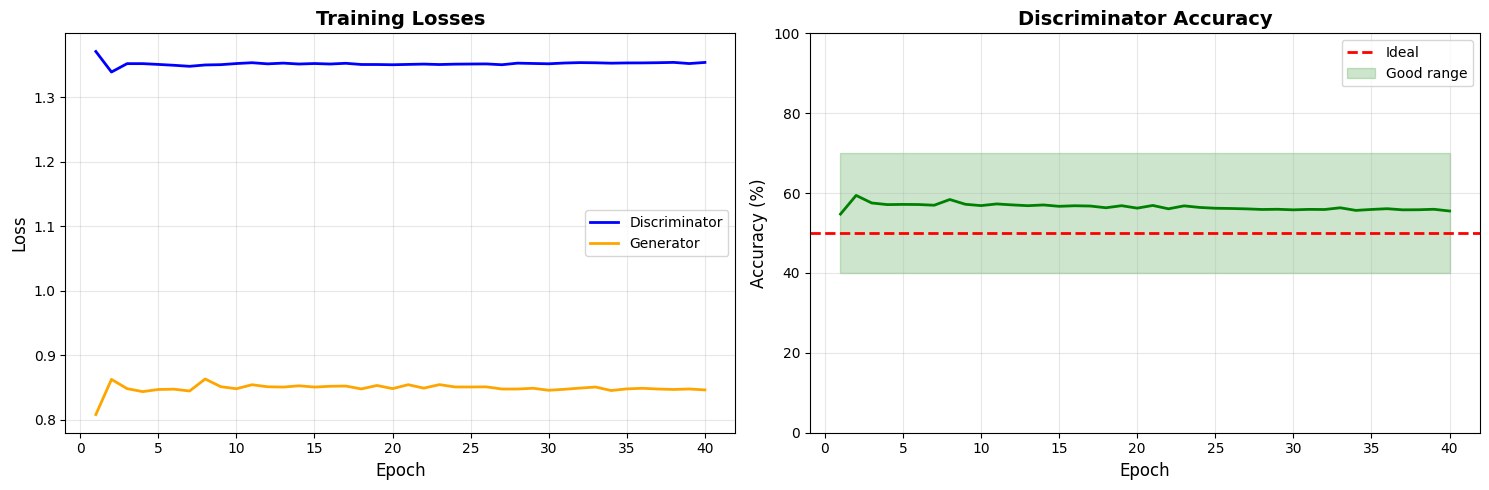


Generating final samples...


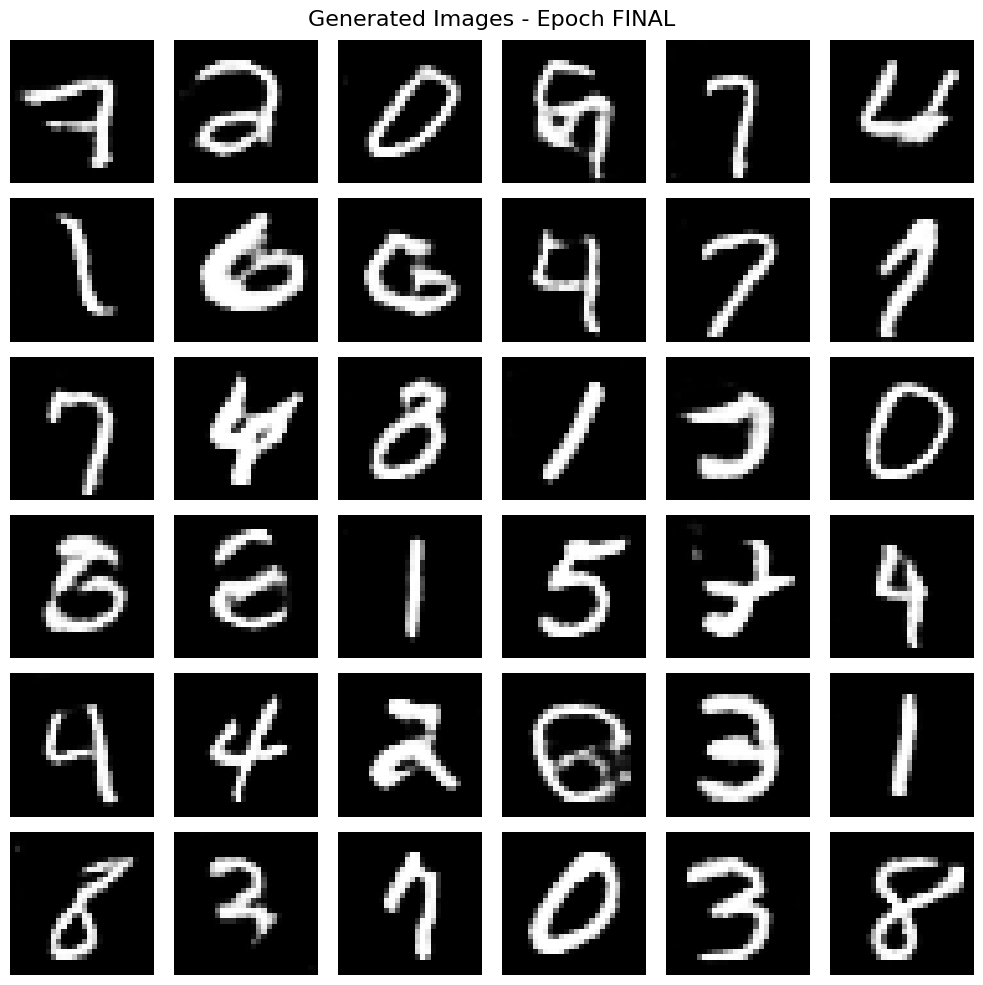


✅ TRAINING COMPLETE!

Final Performance:
  D_loss: 1.3537
  G_loss: 0.8464
  D_acc:  55.5%


In [3]:
# ==========================================
# EXECUTION
# ==========================================

gan = StableDCGAN()

print("="*70)
print("GENERATOR ARCHITECTURE")
print("="*70)
gan.generator.summary()

print("\n" + "="*70)
print("DISCRIMINATOR ARCHITECTURE")
print("="*70)
gan.discriminator.summary()

print("\nPre-training samples...")
gan.generate_images(0)


history = gan.train(epochs=EPOCHS, batch_size=BATCH_SIZE)

gan.plot_history(history)

print("\nGenerating final samples...")
gan.generate_images('FINAL', n=36)

print("\n" + "="*70)
print("✅ TRAINING COMPLETE!")
print("="*70)
print(f"\nFinal Performance:")
print(f"  D_loss: {history['d_loss'][-1]:.4f}")
print(f"  G_loss: {history['g_loss'][-1]:.4f}")
print(f"  D_acc:  {history['d_acc'][-1]:.1f}%")